In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import image from 'image.txt'
f = open("image.txt")
line = f.readline()
data_list = []
while line:
    num = list(map(float,line.split()))
    data_list.append(num)
    line = f.readline()
f.close()
image = np.array(data_list)
image.shape

(28, 28)

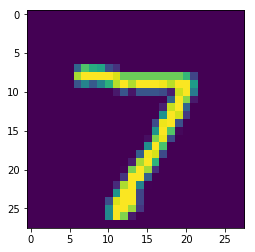

In [3]:
plt.imshow(image)

In [4]:
import torch
model_dict=torch.load('model')

In [5]:
# Normalization
mean, std = image.mean(), image.std()
norm_image = (image - mean) / std
norm_image = norm_image.reshape(1,28,28)
norm_image.shape

(1, 28, 28)

In [6]:
# Convolutional Layer
def conv(A_prev, W, b, pad):   
    (n_C_prev, n_H_prev, n_W_prev) = A_prev.shape # Retrieve dimensions
    (n_C, n_C_prev, n_f, n_f) = W.shape # Retrieve dimensions
    n_H = int((n_H_prev - n_f + 2*pad))+1 # Compute kernel width
    n_W =  int((n_W_prev - n_f + 2*pad))+1 # Compute kernel height
    Z = np.zeros((n_C, n_H, n_W)) # Initialize output tensor with zeros
    A_prev_pad = np.pad(A_prev,((0,0),(pad,pad),(pad,pad)),'constant')# Pad input activation maps

    for h in range(n_H):               # height loop
        for w in range(n_W):          # width loop
            for c in range(n_C):       # channel (# of filter) loop
                h_range = slice(h, h+n_f)
                w_range = slice(w, w+n_f)
                a_slice_prev = A_prev_pad[:, h_range, w_range] # slice of a_prev_pad
                Z[c, h, w] = np.sum(a_slice_prev*W[c,:,:,:])+b[c]     

    assert(Z.shape == (n_C, n_H, n_W))
    return Z

In [7]:
# ReLU
def relu(A_prev):
    (n_C_prev, n_H_prev, n_W_prev) = A_prev.shape
    R = np.zeros((n_C_prev, n_H_prev, n_W_prev)) 
    R = np.where(A_prev >= 0, A_prev, 0)
    assert(R.shape == (n_C_prev, n_H_prev, n_W_prev))
    return R

In [8]:
# Pooling layer forward propagation
def maxpool(A_prev, n_f, stride):
    (n_C_prev, n_H_prev, n_W_prev) = A_prev.shape # Retrieve dimensions
    n_H = int(1 + (n_H_prev-n_f)/stride) # output dimensions
    n_W =  int(1 + (n_W_prev-n_f)/stride)  # output dimensions
    n_C = n_C_prev # output dimensions
    A = np.zeros((n_C, n_H,n_W)) # init output           
    
    for h in range(n_H):              # height loop
            for w in range(n_W):          # width loop
                for c in range(n_C):      # channel loop
                    h_range = slice(h*stride, h*stride+n_f)
                    w_range = slice(w*stride, w*stride+n_f)
                    a_prev_slice = A_prev[c, h_range, w_range] # c-th channel slice of i-th sample of A_prev
                    A[c, h, w] = np.max(a_prev_slice)
                    
    assert(A.shape == (n_C, n_H, n_W))
    return A

In [9]:
# num_flat_features
def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
        num_features *= s
    return num_features

In [19]:
# Convolutional Layer 1 
w1 = model_dict['conv1.weight'].numpy()
b1 = model_dict['conv1.bias'].numpy()
Z1_conv = conv(norm_image, w1, b1, 2)
Z1_conv.shape

(6, 28, 28)

In [20]:
#ReLu
Z1_relu = relu(Z1_conv)
Z1_relu.shape

(6, 28, 28)

In [21]:
# Max-pooling 
Z1_MP = maxpool(Z1_relu, 2, 2)
Z1_MP.shape

(6, 14, 14)

In [22]:
# Convolutional Layer 2
w2 = model_dict['conv2.weight'].numpy()
b2 = model_dict['conv2.bias'].numpy()
Z2_conv = conv(Z1_MP, w2, b2, 0)
Z2_conv.shape

(16, 10, 10)

In [30]:
#ReLu
Z2_relu = relu(Z2_conv)
Z2_relu.shape

(16, 10, 10)

In [31]:
# Max-pooling 
Z2_MP = maxpool(Z2_relu, 2, 2)
Z2_MP.shape

(16, 5, 5)

In [32]:
# Convolutional Layer 3
w3 = model_dict['conv3.weight'].numpy()
b3 = model_dict['conv3.bias'].numpy()
Z3_conv = conv(Z2_MP, w3, b3, 0)
Z3_conv.shape

(120, 1, 1)

In [124]:
#ReLU
Z3_relu = relu(Z3_conv)
Z3_relu.shape

(120, 1, 1)

In [144]:
input_FC = Z3_relu.reshape(120)
input_FC.shape

(120,)

In [147]:
# Fully Connection Layer 1 
w4 = model_dict['fc1.weight'].numpy()
b4 = model_dict['fc1.bias'].numpy()
Z4 = input_FC @ w4.T + b4
Z4.shape

(84,)

In [150]:
# ReLU
Z4_relu = np.where(Z4 >= 0, Z4, 0)
Z4_relu.shape

(84,)

In [154]:
# Fully Connection Layer 2
w5 = model_dict['fc2.weight'].numpy()
b5 = model_dict['fc2.bias'].numpy()
Z5 = Z4_relu @ w5.T + b5
Z5.shape

array([-5.61500208, -0.64210146, -2.47023386, -5.23282189, -0.35078947,
       -6.80284897, -7.33438541,  8.95710866, -9.52891523, -5.31731692])

In [158]:
Y = Z5.tolist().index(max(Z5))
Y

7

In [162]:
# Test
import time
start = time.time()

# Download MNIST handwritten data from website: http://yann.lecun.com/exdb/mnist/
# The data set including 60000 training data / 10000 testing data
import sys
import gzip, struct
import numpy as np

def read_data(image,label):
    with gzip.open(label) as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(image, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return image,label

def get_data():
    train_img,train_label = read_data('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
    test_img,test_label = read_data('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')
    return [train_img,train_label,test_img,test_label]

def custom_normalization(data, std, mean):
    return (data - mean) / std
    
# Get data and normalization
X, y, Xt, yt = get_data()
mean, std = X.mean(), X.std()
X = custom_normalization(X, mean, std)
Xt = custom_normalization(Xt, mean, std)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


In [165]:
# test
correct = 0 
w1 = model_dict['conv1.weight'].numpy()
b1 = model_dict['conv1.bias'].numpy()
w2 = model_dict['conv2.weight'].numpy()
b2 = model_dict['conv2.bias'].numpy()
w3 = model_dict['conv3.weight'].numpy()
b3 = model_dict['conv3.bias'].numpy()
w4 = model_dict['fc1.weight'].numpy()
b4 = model_dict['fc1.bias'].numpy()
w5 = model_dict['fc2.weight'].numpy()
b5 = model_dict['fc2.bias'].numpy()

import time
start = time.time()
for i in range(100):
    image = Xt[i].reshape(1,28,28)
    
    Z1_conv = conv(image, w1, b1, 2)
    Z1_relu = relu(Z1_conv)
    Z1_MP = maxpool(Z1_relu, 2, 2)

    Z2_conv = conv(Z1_MP, w2, b2, 0)
    Z2_relu = relu(Z2_conv)
    Z2_MP = maxpool(Z2_relu, 2, 2)

    Z3_conv = conv(Z2_MP, w3, b3, 0)
    Z3_relu = relu(Z3_conv)

    input_FC = Z3_relu.reshape(120)

    Z4 = input_FC @ w4.T + b4
    Z4_relu = np.where(Z4 >= 0, Z4, 0)

    Z5 = Z4_relu @ w5.T + b5
    Y = Z5.tolist().index(max(Z5))
    
    if Y == yt[i]:
        correct += 1 
print(correct)

end = time.time()
print (end-start)

100
9.42609691619873
